In [2]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import pearsonr
from mfbml.methods.mf_dnn_bnn import MFDNNBNN
from mfbml.methods.bnn import BNNWrapper
from mfbml.methods.sequential_mf_bnn import SequentialMFBNN
from mfbml.problems.illutrative_problems import mf_Forrester_torch
from mfbml.metrics.accuracy_metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
from mfbml.methods.mf_rbf_gpr import MFRBFGPR

# fix the random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [3]:
# define function
func = mf_Forrester_torch(noise_std=0.1)
num_dim = 1

# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(-1, 2, 201).reshape(-1, 1)
hf_samples = torch.linspace(0, 1, 7).reshape(-1, 1)


# generate responses
lf_responses = func.lf_2(lf_samples, noise_std=0.1)
hf_responses = func.hf(hf_samples, noise_hf=0.1)

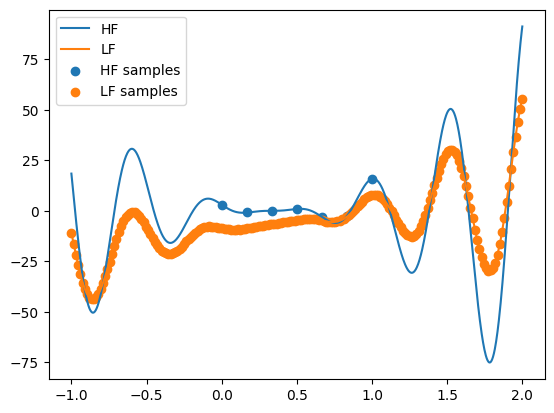

In [4]:
# generate the test points
test_samples = torch.linspace(-1, 2, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf_responses_noiseless = func.lf_2(test_samples, noise_std=0.0)

# noise responses
test_hf_responses = func.hf(test_samples)
test_lf_responses = func.lf_2(test_samples)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf_responses_noiseless, label="LF")
# plot test noisy responses
# ax.scatter(test_samples, test_hf_responses, label="HF noise responses")
# ax.scatter(test_samples, test_lf_responses, label="LF noise responses")
# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf_responses, label="LF samples")
plt.legend()
plt.show()

In [5]:
# train a mf-rbf-gpr model first
# to have a gpr model for this problem
samples_gpr = [hf_samples.numpy(), lf_samples.numpy()]
responses_gpr = [hf_responses.numpy(), lf_responses.numpy()]

# create the MFRBFGPR object
mfrbfgpr = MFRBFGPR(
    design_space=np.array([[0, 1]]), noise_prior=0.1, optimizer_restart=20
)
# train the model
mfrbfgpr.train(
    samples=samples_gpr,
    responses=responses_gpr,
)

# get prediciton for the MFRBFGPR object
y_mfrbfgpr, total_unc_mfrbfgpr = mfrbfgpr.predict(
    X=test_samples.numpy(), return_std=True
)

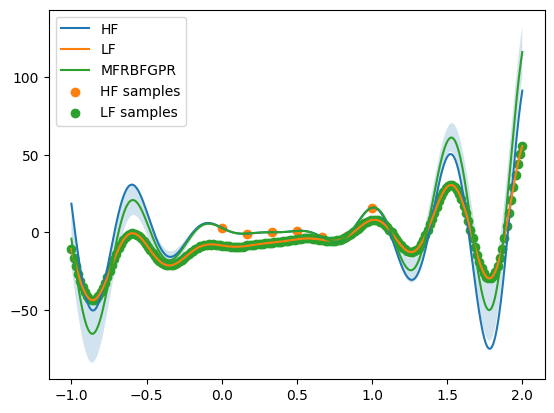

In [6]:
# plot the prediction
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf_responses_noiseless, label="LF")
# plot the prediction
ax.plot(test_samples, y_mfrbfgpr, label="MFRBFGPR")
# plot the uncertainty
ax.fill_between(
    test_samples.flatten(),
    (y_mfrbfgpr - 1.96 * total_unc_mfrbfgpr).flatten(),
    (y_mfrbfgpr + 1.96 * total_unc_mfrbfgpr).flatten(),
    alpha=0.2,
)
# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf_responses, label="LF samples")
plt.legend()
plt.show()

In [7]:
# the learned beta
print(mfrbfgpr.beta.T)

[[2.2209115  1.91584887]]


## Configurations for DNN and BNNs


In [8]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [20, 20],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.0001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.01,
    "sigma": 0.1,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.01,
    "sigma": 0.1,
}

# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

responses = {"lf": lf_responses, "hf": hf_responses}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 10000,
    "print_iter": 1000,
    "data_split": True,
}
hf_train_config = {
    "num_epochs": 10000,
    "sample_freq": 50,
    "print_info": True,
    "burn_in_epochs": 100,
}

# training of sequential MF-DNN-BNN model


In [9]:
# sequential mf-bnn
sequential_bnn = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)
# train the model
sequential_bnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

epoch:  1000 train loss:  0.6357148289680481 test loss:  0.4954051375389099
epoch:  2000 train loss:  0.3107879161834717 test loss:  0.3402195870876312
epoch:  3000 train loss:  0.0456530824303627 test loss:  0.06155768409371376
epoch:  4000 train loss:  0.0067671844735741615 test loss:  0.00712091289460659
epoch:  5000 train loss:  0.0038047973066568375 test loss:  0.004219988826662302
epoch:  6000 train loss:  0.0028821961022913456 test loss:  0.003254167502745986
epoch:  7000 train loss:  0.0017210009973496199 test loss:  0.0017920697573572397
epoch:  8000 train loss:  0.0007721689762547612 test loss:  0.0007144511328078806
epoch:  9000 train loss:  0.00030769166187383235 test loss:  0.0002500540285836905
epoch:  10000 train loss:  0.00028149012359790504 test loss:  0.00026750724646262825
epoch:     0/10000
nll_loss: 12120.953, prior_loss: 2548.864, total: 14669.816
noise: 0.015


/home/yaga/Documents/mfbml/src/mfbml/methods/bnn.py:170: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1578.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:   100/10000
nll_loss: 314.990, prior_loss: 2588.320, total: 2903.310
noise: 0.015
epoch:   200/10000
nll_loss: 129.099, prior_loss: 2621.942, total: 2751.041
noise: 0.015
epoch:   300/10000
nll_loss: 118.619, prior_loss: 2661.614, total: 2780.233
noise: 0.015
epoch:   400/10000
nll_loss: 587.378, prior_loss: 2714.025, total: 3301.402
noise: 0.015
epoch:   500/10000
nll_loss: 22.051, prior_loss: 2777.449, total: 2799.500
noise: 0.015
epoch:   600/10000
nll_loss: 57.122, prior_loss: 2824.535, total: 2881.657
noise: 0.015
epoch:   700/10000
nll_loss: 923.019, prior_loss: 2910.410, total: 3833.429
noise: 0.015
epoch:   800/10000
nll_loss: 24.974, prior_loss: 2988.713, total: 3013.688
noise: 0.015
epoch:   900/10000
nll_loss: 68.116, prior_loss: 3025.560, total: 3093.676
noise: 0.015
epoch:  1000/10000
nll_loss: 1.561, prior_loss: 3082.178, total: 3083.739
noise: 0.015
epoch:  1100/10000
nll_loss: 201.938, prior_loss: 3169.546, total: 3371.484
noise: 0.015
epoch:  1200/10000
nll_loss

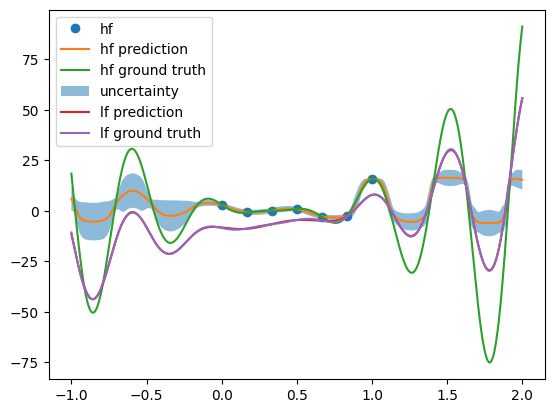

In [10]:
# visualize the posterior of sequential mf-bnn
(
    sequential_bnn_y,
    sequential_bnn_epistemic,
    sequential_bnn_total_unc,
    sequential_bnn_aleatoric,
) = sequential_bnn.predict(x=test_samples)
# get lf predictions
sequential_bnn_lf_y = sequential_bnn.predict_lf(x=test_samples)
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), sequential_bnn_y, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).reshape(-1),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
ax.plot(test_samples.numpy(), sequential_bnn_lf_y.detach(), label="lf prediction")
ax.plot(
    test_samples.numpy(),
    test_lf_responses_noiseless.numpy(),
    label="lf ground truth",
)
ax.legend()
plt.show()

In [11]:
# create the MFDNNBNN object
mfdnnbnn = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=False,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn.beta = np.array([mfrbfgpr.beta[0, 0], mfrbfgpr.beta[1, 0]])
mfdnnbnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

epoch:  1000 train loss:  0.5622168779373169 test loss:  0.45282745361328125
epoch:  2000 train loss:  0.49495333433151245 test loss:  0.4510679543018341
epoch:  3000 train loss:  0.005175055004656315 test loss:  0.005471117328852415
epoch:  4000 train loss:  0.0022281459532678127 test loss:  0.0023788854014128447
epoch:  5000 train loss:  0.001610677340067923 test loss:  0.0017961414996534586
epoch:  6000 train loss:  0.0005221610772423446 test loss:  0.00043543518404476345
epoch:  7000 train loss:  0.0004033948353026062 test loss:  0.00035325883072800934
epoch:  8000 train loss:  0.0003540988836903125 test loss:  0.0003251854213885963
epoch:  9000 train loss:  0.00032422548974864185 test loss:  0.00030750498990528286
epoch:  10000 train loss:  0.00030517729464918375 test loss:  0.00029763253405690193
optimized beta: [2.2209115  1.91584887]
epoch:     0/10000
nll_loss: 19199.490, prior_loss: 2508.311, total: 21707.801
noise: 0.015
epoch:   100/10000
nll_loss: 21.768, prior_loss: 2545.

In [12]:
# predict the MFDNNBNN object
(
    y_proposed,
    epistemic_proposed,
    total_unc_proposed,
    aleatoric_proposed,
) = mfdnnbnn.predict(x=test_samples)
# lf prediction
lf_y_proposed = mfdnnbnn.predict_lf(test_samples)

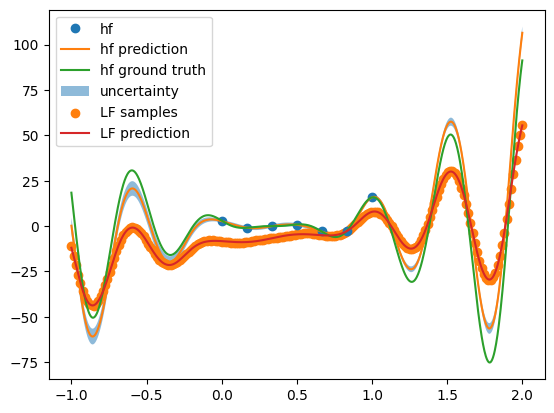

In [13]:
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), y_proposed, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * epistemic_proposed).reshape(-1),
    (y_proposed + 2 * epistemic_proposed).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

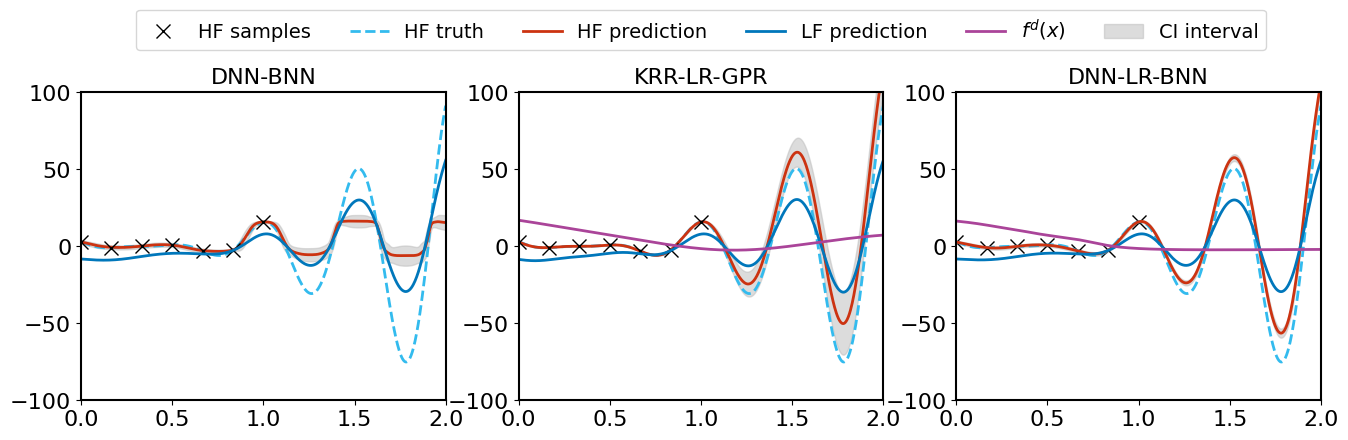

In [17]:
# plot two figures together
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
# plot sequential mf-bnn
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[0].plot(
    test_samples.numpy(),
    sequential_bnn_y,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)
ax[0].plot(
    hf_samples, hf_responses, "kx", linewidth=2, markersize=10, label="HF samples"
)
ax[0].fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).reshape(-1),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# plot lf samples
ax[0].plot(
    test_samples.numpy(),
    sequential_bnn_lf_y.detach().numpy(),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction",
)
# ax[1].legend()
ax[0].set_title("DNN-BNN", fontsize=16)
ax[0].set_xlim([0, 2])
ax[0].set_ylim([-100, 100])
# plot MFRBFGPR
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[1].plot(
    test_samples.numpy(),
    y_mfrbfgpr,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)

ax[1].plot(
    hf_samples,
    hf_responses,
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[1].fill_between(
    test_samples.flatten().numpy(),
    (y_mfrbfgpr - 2 * total_unc_mfrbfgpr).reshape(-1),
    (y_mfrbfgpr + 2 * total_unc_mfrbfgpr).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[1].plot(
    test_samples.numpy(),
    mfrbfgpr.lf_model.predict(test_samples.numpy()),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction",
)
ax[1].plot(
    test_samples.numpy(),
    y_mfrbfgpr
    - mfrbfgpr.beta[1, 0] * mfrbfgpr.lf_model.predict(test_samples.numpy())
    - mfrbfgpr.beta[0, 0],
    linewidth=2,
    color="#AA4499",
    label=r"$f^d(x)$",
)
# ax[0].legend()
ax[1].set_title("KRR-LR-GPR", fontsize=16)
ax[1].set_xlim([0, 2])
ax[1].set_ylim([-100, 100])
# plot MFDNNBNN
ax[2].plot(
    hf_samples,
    hf_responses,
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[2].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[2].plot(
    test_samples.numpy(),
    y_proposed,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)
# plot lf samples
ax[2].plot(
    test_samples.numpy(),
    lf_y_proposed.detach().numpy(),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction",
)
ax[2].plot(
    test_samples.numpy(),
    y_proposed
    - mfrbfgpr.beta[1, 0] * lf_y_proposed.detach().numpy()
    - mfrbfgpr.beta[0, 0],
    linewidth=2,
    color="#AA4499",
    label=r"$f^d(x)$",
)
ax[2].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)


ax[2].set_title("DNN-LR-BNN", fontsize=16)
ax[2].set_xlim([0, 2])
ax[2].set_ylim([-100, 100])


plt.legend(loc="upper center", bbox_to_anchor=(-0.7, 1.30), ncol=6, fontsize=14)
# set the font size of axis
for i in range(3):
    ax[i].tick_params(axis="both", which="major", labelsize=16)
    # set the line width of the axis
    for axis in ["top", "bottom", "left", "right"]:
        ax[i].spines[axis].set_linewidth(1.5)


plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.svg", dpi=300, bbox_inches="tight")
plt.show()

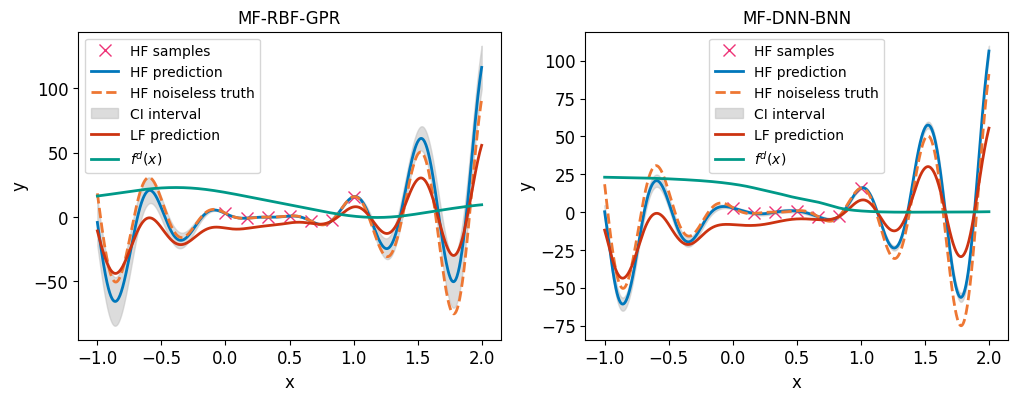

In [15]:
# plot comparison betw
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(
    hf_samples,
    hf_responses,
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[0].plot(
    test_samples.numpy(),
    y_mfrbfgpr,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[0].fill_between(
    test_samples.flatten().numpy(),
    (y_mfrbfgpr - 2 * total_unc_mfrbfgpr).reshape(-1),
    (y_mfrbfgpr + 2 * total_unc_mfrbfgpr).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0].plot(
    test_samples.numpy(),
    mfrbfgpr.lf_model.predict(test_samples.numpy()),
    "-",
    color="#CC3311",
    linewidth=2,
    label="LF prediction",
)
ax[0].plot(
    test_samples.numpy(),
    y_mfrbfgpr - 1.9144 * mfrbfgpr.lf_model.predict(test_samples.numpy()),
    label=r"$f^d(x)$",
    color="#009988",
    linewidth=2,
)

ax[0].legend()
ax[0].set_title("MF-RBF-GPR")
ax[0].set_xlabel("x", fontsize=12)
ax[0].set_ylabel("y", fontsize=12)
# set the font size of axis
ax[0].tick_params(axis="both", which="major", labelsize=12)
# ax[1].set_xlim([0, 1.5])

# plot MFDNNBNN
ax[1].plot(
    hf_samples,
    hf_responses,
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[1].plot(
    test_samples.numpy(),
    y_proposed,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[1].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# plot lf samples
# ax[1].scatter(lf_samples, lf_responses, label="LF samples")
# ax[1].plot(test_samples.numpy(), lf_y_proposed.detach().numpy(), label="LF prediction")
ax[1].plot(
    test_samples.numpy(),
    lf_y_proposed.detach().numpy(),
    "-",
    color="#CC3311",
    linewidth=2,
    label="LF prediction",
)
ax[1].plot(
    test_samples.numpy(),
    y_proposed - 1.9144 * lf_y_proposed.detach().numpy(),
    label=r"$f^d(x)$",
    color="#009988",
    linewidth=2,
)

ax[1].legend()
ax[1].set_title("MF-DNN-BNN")
ax[1].set_xlabel("x", fontsize=12)
ax[1].set_ylabel("y", fontsize=12)
# set the font size of axis
ax[1].tick_params(axis="both", which="major", labelsize=12)
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.svg", dpi=300, bbox_inches="tight")
plt.show()